In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

In [2]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
df = df.drop(columns='Unnamed: 11')
df = df[~df['Finding Labels'].str.contains('\|')]
df = df.reset_index(drop=True)
print(f'Shape of DataFrame: {df.shape}')
df.head(10)

Shape of DataFrame: (91324, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
2,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
3,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
4,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168
5,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168
6,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143
7,00000003_006.png,Hernia,6,3,79,F,PA,2992,2991,0.143,0.143
8,00000003_007.png,Hernia,7,3,80,F,PA,2582,2905,0.143,0.143
9,00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,0.168,0.168


In [3]:
%%time
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','images', '*.png'))}    
    
df['path'] = df['Image Index'].map(tmp)

CPU times: user 483 ms, sys: 112 ms, total: 596 ms
Wall time: 5.82 s


In [4]:
def lung_mask(path_name):
    
    ### First Step: Get the original Image
    lung_mask = []
    
    img = Image.open(path_name).convert('L')
    img = np.array(img)
    
    ### Second Step: Find the biggest Contour
    clahe = cv2.createCLAHE(clipLimit=16.0, tileGridSize=(4, 4))
    img = clahe.apply(img)
    thresh = cv2.threshold(img, 125, 255, cv2.THRESH_BINARY)[1]

    # RETR_EXTERNAL: 외부 윤관석만
    # CHAIN_APPROX_SIMPLE: 윤곽선 내의 모든점 선
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # len(cnts): 전체 윤곽선의 갯수
    # len(cnts[0]): 첫번째 윤곽선을 이루고 있는 점 좌표의 갯수
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    #c0 = cnts[0]
    c1 = cnts[1] # Second Biggest
    c2 = cnts[2] # Third Biggest
    
    mask = np.zeros_like(img)
    #mask = cv2.drawContours(mask, [c0], -1, 255, cv2.FILLED)
    mask = cv2.drawContours(mask, [c1], -1, 255, cv2.FILLED)
    mask = cv2.drawContours(mask, [c2], -1, 255, cv2.FILLED)
    
    mask = cv2.dilate(mask, None, iterations=2)
    
    lung_mask.append(mask)
    
    return np.array(lung_mask)

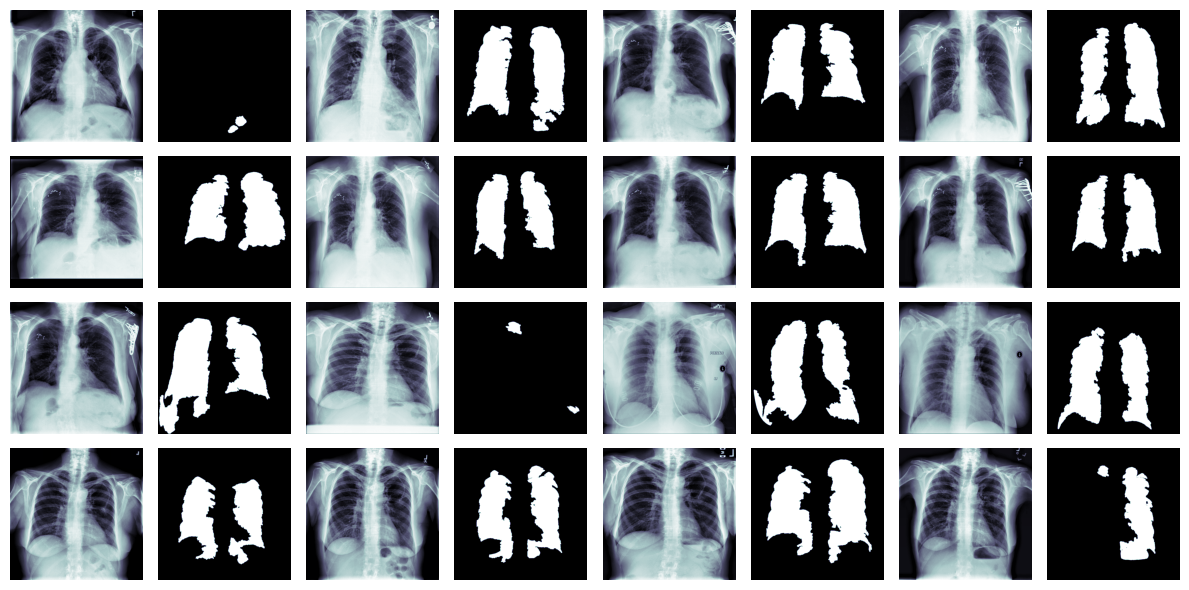

In [5]:
plt.figure(figsize=(12,6))
for i in range(16):
    plt.subplot(4,8,2*i+1)
    path = df.iloc[i]['path']
    img = Image.open(path).convert('L')
    img = np.array(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    img = clahe.apply(img)
    plt.imshow(img, cmap='bone')
    plt.axis('off')
    
    plt.subplot(4,8, 2*i+2)
    img = lung_mask(path)
    plt.imshow(img[0], cmap='bone')
    plt.axis('off')
    
plt.tight_layout()
plt.show()